In [1]:
# Imports
from hftbacktest import BacktestAsset,GTX,LIMIT, HashMapMarketDepthBacktest
import numpy as np
from hftbacktest import Recorder
from numba import njit
from hftbacktest.stats import LinearAssetRecord

# Data Input paths
preprocessed_data_path = "../data/daily_processed"
daily_eod_snapshots = "../data/snapshots" # EOD = End Of Day 

In [2]:
# Contract-specific constants (change to match the instrument)
TICK_SIZE = 0.05          # min price increment
LOT_SIZE  = 10            # contracts per lot
NOTIONAL  = 1.0           # linear P&L multiplier (1 for USD-quoted futures)

# Taken from https://support.deribit.com/hc/en-us/articles/25944746248989-Fees
MAKER_FEE = 0   
TAKER_FEE =  0.0005      

# Model parameters (feel free to calibrate them – see comments below)
GAMMA       = 0.1     # risk aversion
K_INTENSITY = 1.5     # λ(δ)=A·e^{-kδ}  →  k
A_INTENSITY = 2.0     # λ(δ)=A·e^{-kδ}  →  A
T_HORIZON   = 8*60*60 # sec until “end of day”
DT_NS       = 100_000_000             
VOL_WINDOW  = 600                     # 60 s rolling window in steps

In [3]:
@njit
def avellaneda_stoikov(hbt, rec):
    """
    JIT-compiled inner-loop.
    Quotes every 100 ms using Avellaneda–Stoikov formulas:

        reservation = S – q·γ·σ²·(T–t)
        half_spread = γ·σ²·(T–t)/2 + (1/γ)·log(1 + γ/k)
        bid  = reservation – half_spread
        ask  = reservation + half_spread
    """
    asset_no   = 0
    tick_size  = hbt.depth(asset_no).tick_size
    lot_size   = hbt.depth(asset_no).lot_size
    
    # rolling array for realised log-returns (for σ)
    ret        = np.zeros(10_000_000, np.float64)
    r_ptr      = 0
    prev_mid   = (hbt.depth(asset_no).best_bid + hbt.depth(asset_no).best_ask) / 2.0

    while hbt.elapse(DT_NS) == 0:
        d = hbt.depth(asset_no)
        mid = (d.best_bid + d.best_ask) / 2.0
        
        # -------- volatility ----------------
        if prev_mid > 0.0:
            ret[r_ptr] = np.log(mid / prev_mid)
            r_ptr += 1
        prev_mid = mid
        
        left = 0 if r_ptr < VOL_WINDOW else r_ptr - VOL_WINDOW
        
        # dt_sec = DT_NS * 1e-9                    # 0.1  s
        # sigma_ret = np.std(ret[left:r_ptr]) / np.sqrt(dt_sec)
        # sigma = sigma_ret * mid   
        sigma = 2
        
        # -------- AS formulas ---------------
        t     = hbt.current_timestamp  / 1e9                  # current sim-time in sec
        tau = max((T_HORIZON - t) / T_HORIZON, 1e-4)     
        q     = hbt.position(asset_no)        # current inventory (contracts)

        reservation  = mid - q * GAMMA * sigma * sigma * tau
        half_spread  = (GAMMA * sigma * sigma * tau) / 2.0 + (1.0/GAMMA) * np.log(1 + GAMMA / K_INTENSITY)

        bid_px = reservation - half_spread
        ask_px = reservation + half_spread
        bid_tick = np.round(bid_px / tick_size)
        ask_tick = np.round(ask_px / tick_size)

        qty = lot_size                       # quote 1 lot each side

        # cancel anything stale
        orders = hbt.orders(asset_no).values()
        while orders.has_next():
            o = orders.get()
            hbt.cancel(asset_no, o.order_id, False)

        # use ticks themselves as deterministic order-ids
        hbt.submit_buy_order (asset_no, int(bid_tick), bid_tick*tick_size, qty, GTX, LIMIT, False)
        hbt.submit_sell_order(asset_no, int(ask_tick), ask_tick*tick_size, qty, GTX, LIMIT, False)

        hbt.wait_order_response(asset_no, int(ask_tick), DT_NS)

        # log state every cycle
        rec.record(hbt)

    return True

In [4]:
data = np.load("../data/daily_processed/deribit_eth_perp_2025-01-02.npz")['data']
eod = np.load("../data/snapshots/deribit_eth_perp_2025-01-01_eod.npz")['data']

In [6]:
from src.strategies import glft
from hftbacktest import Recorder, ROIVectorMarketDepthBacktest
from hftbacktest.stats import LinearAssetRecord

asset = (
    BacktestAsset()
        .data([data])
        .initial_snapshot(eod)
        .linear_asset(1.0)
        # .intp_order_latency([
        #     'latency/feed_latency_20221003.npz'
        # ])
        .power_prob_queue_model(2.0)
        .no_partial_fill_exchange()
        .trading_value_fee_model(MAKER_FEE, TAKER_FEE)
        .tick_size(0.01)
        .lot_size(1)
        # .roi_lb(0.0)
        # .roi_ub(3000.0)
        .last_trades_capacity(10000)
)

hbt = HashMapMarketDepthBacktest([asset])

recorder = Recorder(1, 5_000_000)

out = glft.gridtrading_glft_mm(hbt, recorder.recorder)

hbt.close()

0

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTradingValue,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-01-02 00:00:00,2025-01-02 23:59:50,-37.86746,-50.284801,-1283.335,1372.48,6323.731913,2.1810e7,-0.935048,-0.000059,131978.75


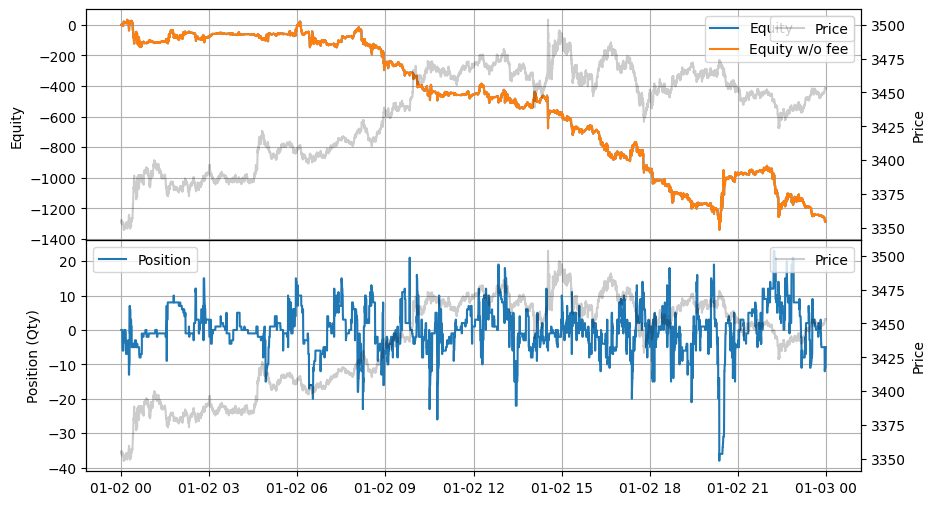

In [7]:

stats = LinearAssetRecord(recorder.get(0)).stats()
stats.plot()
stats.summary(pretty=True)

# asset = (
#     BacktestAsset()
#         .data([data])
#         .initial_snapshot(eod)
#         # Asset type:
#         # * Linear
#         # * Inverse.
#         # 1.0 represents the contract size, which is the value of the asset per quoted price.
#         .linear_asset(1.0)
#         # HftBacktest provides two built-in latency models.
#         # * constant_latency
#         # * intp_order_latency
#         # To implement your own latency model, please use Rust.
#         #
#         # Time unit is the same as data's timestamp's unit. Timestamp of the sample data is in nanoseconds.
#         # Sets the order entry latency and response latency to 10ms.
#         .constant_latency(10_000_000, 10_000_000)
#         # HftBacktest provides several types of built-in queue position models.
#         # Please find the details in the documents below.
#         # https://hftbacktest.readthedocs.io/en/latest/tutorials/Probability%20Queue%20Models.html
#         #
#         # To implement your own queue position model, please use Rust.
#         .risk_adverse_queue_model()
#         # HftBacktest provides two built-in exchange models.
#         # * no_partial_fill_exchange
#         # * partial_fill_exchange
#         # To implement your own exchange model, please use Rust.
#         .no_partial_fill_exchange()
#         # HftBacktest provides several built-in fee models.
#         # * trading_value_fee_model
#         # * trading_qty_fee_model
#         # * flat_per_trade_fee_model
#         #
#         # Maker's fee and taker's fee params
#         .trading_value_fee_model(MAKER_FEE, TAKER_FEE)
#         # Tick size of this asset: minimum price increasement
#         .tick_size(TICK_SIZE)
#         # Lot size of this asset: minimum trading unit.
#         .lot_size(LOT_SIZE)
#         # Sets the capacity of the vector that stores trades occurring in the market.
#         # If you set the size, you need call `clear_last_trades` to clear the vector.
#         # A value of 0 indicates that no market trades are stored. (Default)
#         .last_trades_capacity(0)
# )
# 
# hbt = HashMapMarketDepthBacktest([asset])
# recorder = Recorder(1, 60_000_000)

In [6]:
# --- RUN SIMULATION
avellaneda_stoikov(hbt, recorder.recorder)
hbt.close()
print("Simulation finished")

Simulation finished


In [7]:
# # ---  Save results
# recorder.to_npz("avellaneda_stoikov_2.npz")

shape: (1, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ start     ┆ end       ┆ SR        ┆ Sortino   ┆ … ┆ DailyTrad ┆ ReturnOve ┆ ReturnOve ┆ MaxPosit │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ingValue  ┆ rMDD      ┆ rTrade    ┆ ionValue │
│ datetime[ ┆ datetime[ ┆ f64       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ μs]       ┆ μs]       ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2025-01-0 ┆ 2025-01-0 ┆ 29.451313 ┆ 41.566183 ┆ … ┆ 1.4435e11 ┆ 2.831026  ┆ 0.020767  ┆ 9.9059e1 │
│ 2         ┆ 2         ┆           ┆           ┆   ┆           ┆           ┆           ┆ 0        │
│ 00:00:00  ┆ 23:59:50  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────

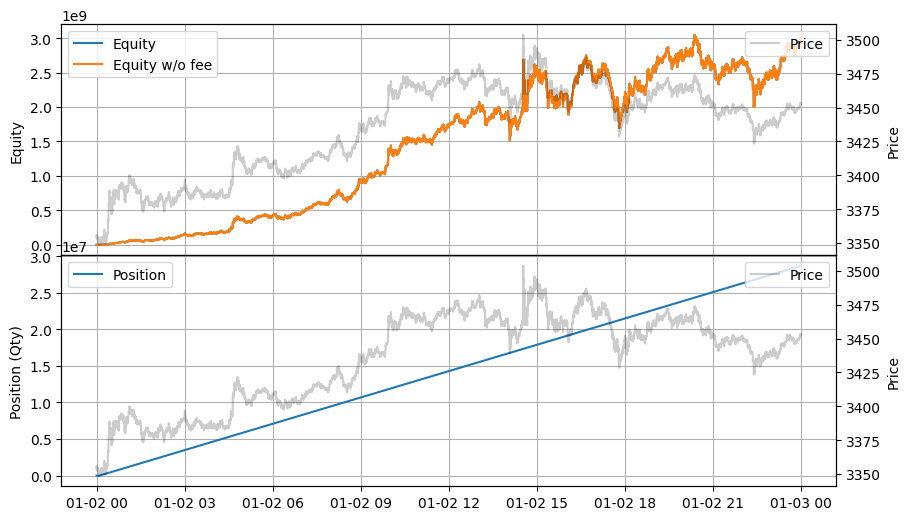

In [8]:
# ---  Evaluate
rec = LinearAssetRecord(recorder.get(0))
stats = rec.stats()   # normalise by 10 k USD book
print(stats.summary(pretty=True))                # tabular KPIs
stats.plot()   